# Experimental FFN model
use the KPIs we discussed previously alongside the new item statistics to train a basic pytorch model

### imports

In [1]:
# Imports
from tqdm import tqdm
import glob
import os
import sys
import numpy as np
import json

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torcheval.metrics import MulticlassAccuracy
from torchmetrics.classification import MulticlassJaccardIndex

sys.path.append(os.path.join("..", "..", "src"))
from game_data_collector.api import Role, get_hero_ids_of_role

## data extraction

### load data

In [2]:
# Building the data frame from the raw data
# TODO I'm skipping the database integration for now (query building etc.) to cut some time for faster EDA

json_files = list(glob.iglob("C:\\Users\\cedri\\dota-project\\mmr-predictor\\resources\\data\\*.json"))
print(f"found {len(json_files):,} match dumps")

found 22,594 match dumps


In [3]:
# limit on CC class
ROLE = Role.CANONICAL_CARRY

cc_ids: list = get_hero_ids_of_role(ROLE)
print(f"got {len(cc_ids)} distinct hero ids for Role '{ROLE.name}'")

got 21 distinct hero ids for Role 'CANONICAL_CARRY'


### built tabular train data

In [4]:
# aggregate to rank groups 10, 20, ... instead of 11, ..., 15, 21, ..., 25 ?
AGGREGATE_RANKS: bool = True

In [5]:
# item uses
# Get all distinct items from the data for the cols
distinct_items = set()

# 31s
for j in tqdm(json_files, total=len(json_files)):
    with open(j, "r", encoding="utf-8") as fi:
        match = json.load(fi)
        for player in match["players"]:
            
            # filter hero class
            # if player["hero_id"] not in cc_ids:
            #     continue
    
            # Combine item uses and purchases into one loop
            distinct_items.update(player["item_uses"].keys())
            distinct_items.update(player["purchase"].keys())

print(f"found {len(distinct_items):,} distinct items in the data")
# print("\n".join([d for d in distinct_items]))

distinct_items_only = [i for i in distinct_items if "recipe" not in i]
print(f"found {len(distinct_items_only):,} items without recipes")

100%|██████████| 22594/22594 [04:46<00:00, 78.80it/s]

found 305 distinct items in the data
found 226 items without recipes


In [6]:
# common stats and combine with item uses
cols = ["rank_tier", "hero_kills", "deaths", "denies", "hero_damage", "actions_per_min", "gold_per_min", "xp_per_min", "lane_efficiency_pct", "lane_kills", "last_hits", "tower_damage", "win"] + list(distinct_items_only)
data_rows = []

# 35s
for j in tqdm(json_files, total=len(json_files)):
    with open(j, "r", encoding="utf-8") as fi:
        match = json.load(fi)
                
        for player in match["players"]:

            # filter hero class
            # if player["hero_id"] not in cc_ids:
            #     continue
                        
            # filter players not in rank tier interval (0, 80)
            if (player["rank_tier"] == None) or (player["rank_tier"] == 80):
                continue
            
            # Initialize a dictionary for the current row
            row_data = {col: 0 for col in cols}  # Set default counts to 0
            
            # player stats
            for stat in player.keys():
                if stat in cols:
                    row_data[stat] = player[stat]

            # Update counts based on the player's item uses and purchases
            for item, count in player["item_uses"].items():
                if item in row_data:
                    row_data[item] += count
        
            data_rows.append(row_data)

df = pd.DataFrame(data_rows)

if AGGREGATE_RANKS:
    # simplification
    df["rank_tier"] = (df["rank_tier"] // 10).astype("category")
else:
    # target var should be categorical
    df["rank_tier"] = df["rank_tier"].astype("category")



print(f"df with {len(df):,} players' data") # note that 10 player per match = match count times 10

100%|██████████| 22594/22594 [00:50<00:00, 444.33it/s]


df with 92,393 players' data


In [7]:
print(df.sample(n=5))

      rank_tier  hero_kills  deaths  denies  hero_damage  actions_per_min  \
8778          4           8       4       7        19469              155   
73234         7           6       0       0        10823              248   
36800         7           4      12      21        11664              141   
70742         2           2       3       8        11235              321   
68254         7           2       1       3        12575              143   

       gold_per_min  xp_per_min  lane_efficiency_pct  lane_kills  ...  \
8778            630         688                   64         117  ...   
73234           420         569                   31          14  ...   
36800           382         451                   57         127  ...   
70742           333         513                   35          23  ...   
68254           364         385                   37          17  ...   

       clarity  radiance  trickster_cloak  havoc_hammer  heavens_halberd  \
8778         4        

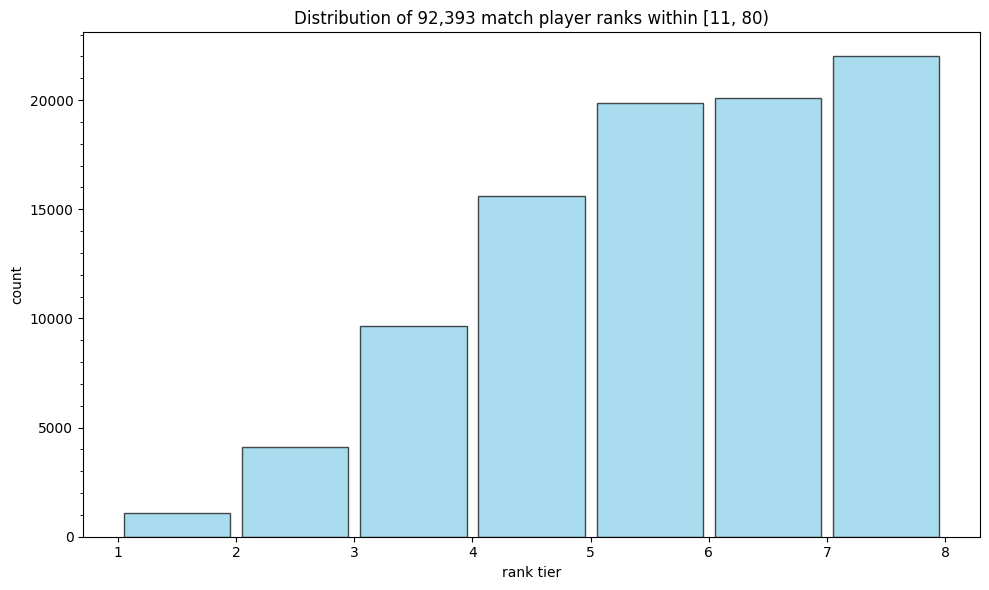

In [8]:
# Create the histogram
plt.figure(figsize=(10, 6))

if AGGREGATE_RANKS:
    bins = range(1, 9, 1)
else:
    bins = range(11, 91, 10)  # Bins from 0 to 80 with a width of 10
bar_width = 0.9 * (bins[1] - bins[0]) 

# Plot histogram
counts, _, patches = plt.hist(data=df, x="rank_tier", bins=bins, density=False, edgecolor='black', color='skyblue', alpha=0.7, rwidth=0.9)

# Labeling x and y axis, and title
plt.xlabel('rank tier')
plt.ylabel('count',)
plt.title(f'Distribution of {len(df):,} match player ranks within [11, 80)')

if AGGREGATE_RANKS:
    plt.xticks(range(1, 9, 1))
else:
    # Set x-ticks at intervals of 10
    plt.xticks(range(11, 91, 10))

# minor ticks
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', left=True)
plt.tick_params(axis='x', which='minor', bottom=False)


# Display counts on top of each bar
# for count, patch in zip(counts, patches):
#     height = patch.get_height()
#     plt.text(patch.get_x() + patch.get_width() / 2, height + 150, f'{int(count)}', ha='center')

# Show the plot
plt.tight_layout()
plt.show()

## neural network

### splits and target variable rebalancing

In [ ]:
# X: numpy array (n_samples × n_features)
# y: numpy array of integer levels (e.g. [1, 2, 3, …, 79], but only observed classes)
y = df.iloc[:, 0].to_numpy(dtype=np.int64)        # shape (n_samples,)
X = df.iloc[:, 1:].to_numpy(dtype=np.float32)     # shape (n_samples, n_features)

# if using the full rank tier set
# Map original levels to 0…(C-1)
unique_levels = np.sort(np.unique(y))
level_to_idx = {lvl: idx for idx, lvl in enumerate(unique_levels)}
y_idx = np.array([level_to_idx[l] for l in y], dtype=np.int64)
num_classes = len(unique_levels)

for k, v in level_to_idx.items():
    print(f"{k} -> {v}")

1 -> 0
2 -> 1
3 -> 2
4 -> 3
5 -> 4
6 -> 5
7 -> 6


In [10]:
# Train/test split with stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y_idx,
    test_size=0.2,
    random_state=42,
    stratify=y_idx
)

In [11]:
# Convert to tensors & datasets
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t   = torch.tensor(X_val,   dtype=torch.float32)
y_val_t   = torch.tensor(y_val,   dtype=torch.long)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=128)

In [12]:
# Compute class weights inversely proportional to frequency
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

### model

In [19]:
model = nn.Sequential(
    nn.Linear(X.shape[1], 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(0.4),

    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(64, num_classes)
)

In [20]:
# Instantiate metrics
train_acc_metric = MulticlassAccuracy(num_classes=num_classes)
val_acc_metric   = MulticlassAccuracy(num_classes=num_classes)
# val_jaccard      = MulticlassJaccardIndex(num_classes=num_classes, average='macro')

### train loop

In [21]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")
model.to(device)
class_weights = class_weights.to(device)

Using cuda device


In [22]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [23]:
NUM_EPOCHS: int = 200

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []
best_val_acc = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    # Training
    model.train()
    train_acc_metric.reset()
    epoch_train_loss = 0.0
    total_train_samples = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        # forward pass
        optimizer.zero_grad()
        logits = model(xb)
        
        loss = criterion(logits, yb)
        
        # backward pass
        loss.backward()
        optimizer.step()
        
        batch_size = xb.size(0)
        epoch_train_loss += loss.item() * batch_size
        total_train_samples += batch_size

        preds = logits.argmax(dim=1)
        train_acc_metric.update(preds, yb)

    train_loss = epoch_train_loss / total_train_samples
    train_loss_list.append(train_loss)

    train_acc = train_acc_metric.compute().item()
    train_acc_list.append(train_acc)

    # Validation
    model.eval()
    val_acc_metric.reset()
    epoch_val_loss = 0.0
    total_val_samples = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)

            logits = model(xb)
            loss = criterion(logits, yb)

            batch_size = xb.size(0)
            epoch_val_loss += loss.item() * batch_size
            total_val_samples += batch_size

            preds = logits.argmax(dim=1)
            val_acc_metric.update(preds, yb)

    val_loss = epoch_val_loss / total_val_samples
    val_loss_list.append(val_loss)

    val_acc = val_acc_metric.compute().item()
    val_acc_list.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc

    if epoch % 10 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:03d}: "
            f"Train Loss = {train_loss:.4f}, Train Acc = {train_acc:.4f} | "
            f"Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}"
        )

print("------------------------------------")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

Epoch 001: Train Loss = 1.9644, Train Acc = 0.1366 | Val Loss = 1.9470, Val Acc = 0.1122
Epoch 010: Train Loss = 1.8724, Train Acc = 0.1939 | Val Loss = 1.8922, Val Acc = 0.1445
Epoch 020: Train Loss = 1.8551, Train Acc = 0.2049 | Val Loss = 1.8393, Val Acc = 0.2088
Epoch 030: Train Loss = 1.8467, Train Acc = 0.2124 | Val Loss = 1.8293, Val Acc = 0.2223
Epoch 040: Train Loss = 1.8385, Train Acc = 0.2115 | Val Loss = 1.8360, Val Acc = 0.2404
Epoch 050: Train Loss = 1.8359, Train Acc = 0.2128 | Val Loss = 1.8224, Val Acc = 0.2113
Epoch 060: Train Loss = 1.8329, Train Acc = 0.2163 | Val Loss = 1.8389, Val Acc = 0.1985
Epoch 070: Train Loss = 1.8277, Train Acc = 0.2144 | Val Loss = 1.8248, Val Acc = 0.2344
Epoch 080: Train Loss = 1.8269, Train Acc = 0.2160 | Val Loss = 1.8204, Val Acc = 0.2380
Epoch 090: Train Loss = 1.8215, Train Acc = 0.2164 | Val Loss = 1.8210, Val Acc = 0.2367
Epoch 100: Train Loss = 1.8215, Train Acc = 0.2154 | Val Loss = 1.8125, Val Acc = 0.2237
Epoch 110: Train Loss

### evaluation

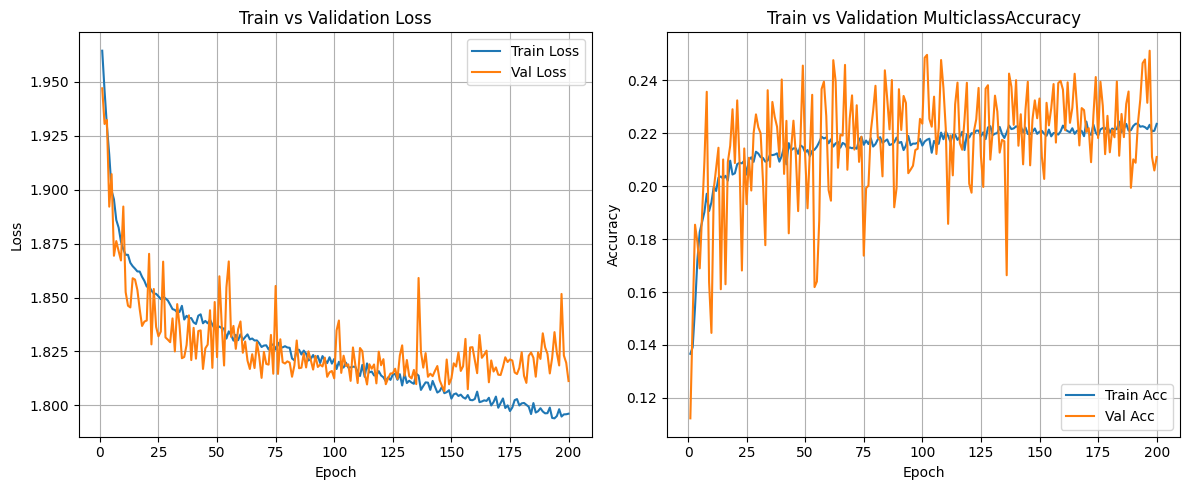

In [24]:
epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_list, label='Train Loss')
plt.plot(epochs, val_loss_list,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_list, label='Train Acc')
plt.plot(epochs, val_acc_list,   label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Validation MulticlassAccuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()